In [1]:
!nvidia-smi

Mon Apr 25 13:44:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing the libraries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt     
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import pandas as pd

## Mounting the drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining the paths

In [2]:
data_root='/content/drive/My Drive/dance/images/'
traincsv=pd.read_csv('/content/drive/My Drive/dance/images/train_labels.csv')
testcsv=pd.read_csv('/content/drive/My Drive/dance/images/test_labels.csv')

In [3]:
traincsv.head(10)

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi
5,46.jpg,kathak
6,326.jpg,sattriya
7,408.jpg,kuchipudi
8,365.jpg,sattriya
9,422.jpg,kuchipudi


In [4]:
traincsv.shape

(364, 2)

## Creating separate folders for each dance form

In [5]:
c=1
for line in traincsv.values:
  filename=line[0]
  label=line[1]
  print(filename,label)
  src=os.path.join(data_root,'train',filename)
  dest=os.path.join(data_root,'train_ds',label,filename)
  if not label in os.listdir(os.path.join(data_root,'train_ds')):
    os.makedirs(os.path.join(data_root,'train_ds',label))
  im=cv2.imread(src)
  if im is not None:
    cv2.imwrite(dest,im)
  c=c+1
print(c)

96.jpg manipuri
163.jpg bharatanatyam
450.jpg odissi
219.jpg kathakali
455.jpg odissi
46.jpg kathak
326.jpg sattriya
408.jpg kuchipudi
365.jpg sattriya
422.jpg kuchipudi
397.jpg kuchipudi
400.jpg kuchipudi
32.jpg kathak
350.jpg sattriya
234.jpg kathakali
492.jpg odissi
333.jpg sattriya
376.jpg kuchipudi
103.jpg manipuri
39.jpg kathak
87.jpg manipuri
155.jpg bharatanatyam
388.jpg kuchipudi
384.jpg kuchipudi
248.jpg mohiniyattam
494.jpg odissi
47.jpg kathak
488.jpg odissi
462.jpg odissi
347.jpg sattriya
242.jpg kathakali
16.jpg kathak
178.jpg kathakali
348.jpg sattriya
164.jpg bharatanatyam
2.jpg kathak
141.jpg bharatanatyam
187.jpg kathakali
464.jpg odissi
472.jpg odissi
489.jpg odissi
387.jpg kuchipudi
109.jpg manipuri
255.jpg mohiniyattam
274.jpg mohiniyattam
509.jpg odissi
19.jpg kathak
102.jpg manipuri
24.jpg kathak
294.jpg mohiniyattam
501.jpg odissi
335.jpg sattriya
321.jpg sattriya
480.jpg odissi
393.jpg kuchipudi
344.jpg sattriya
259.jpg mohiniyattam
76.jpg manipuri
343.jpg satt

In [6]:
c

365

In [3]:
traindir='/content/drive/My Drive/dance/images/train_ds'
testdir='/content/drive/My Drive/dance/images/test'

In [4]:
img_shape=(224,224,3)
img_width=224
img_height=224

## Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
		horizontal_flip=True,
    validation_split=0.2)

test_datagen=ImageDataGenerator(rescale=1/255.0)

In [6]:
train_generator=train_datagen.flow_from_directory(traindir,target_size=(img_height,img_width),batch_size=32,class_mode='categorical',subset='training',shuffle=True)

Found 283 images belonging to 8 classes.


In [7]:
validation_generator=train_datagen.flow_from_directory(traindir,target_size=(img_height,img_width),batch_size=32,class_mode='categorical',subset='validation',shuffle=True)

Found 69 images belonging to 8 classes.


# Feature Extractor

# VGG16

In [8]:
from keras.applications.vgg16 import VGG16

base_model=VGG16(include_top=False,input_shape=(img_shape))

In [9]:
for layer in base_model.layers:
  layer.trainable= False

In [10]:
model=Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(8,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [12]:
learning_rate = 0.001
lr_decay = 1e-6
lr_drop = 25

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
# sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history=model.fit(train_generator,epochs=200,steps_per_epoch=len(train_generator),validation_data=validation_generator,validation_steps=len(validation_generator),callbacks=[reduce_lr])

Epoch 1/200
9/9 [==============================] - 15s 1s/step - loss: 2.1064 - accuracy: 0.1343 - val_loss: 2.0722 - val_accuracy: 0.1449 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 7s 807ms/step - loss: 2.0686 - accuracy: 0.1555 - val_loss: 2.0487 - val_accuracy: 0.1594 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 6s 644ms/step - loss: 2.0591 - accuracy: 0.1837 - val_loss: 2.0469 - val_accuracy: 0.1594 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 6s 649ms/step - loss: 2.0506 - accuracy: 0.1837 - val_loss: 2.0229 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 6s 640ms/step - loss: 2.0289 - accuracy: 0.2085 - val_loss: 2.0024 - val_accuracy: 0.3188 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 6s 636ms/step - loss: 2.0078 - accuracy: 0.2261 - val_loss: 1.9760 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 7/200
9/9 [==============================] - 6s 633ms/step - loss: 1.960

## Plotting the curves

Text(0.5, 1.0, 'Training and validation loss')

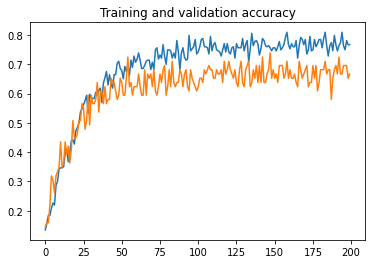

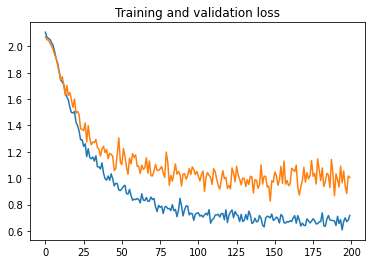

In [15]:
import matplotlib.pyplot as plt

acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [16]:
train_generator.class_indices

{'bharatanatyam': 0,
 'kathak': 1,
 'kathakali': 2,
 'kuchipudi': 3,
 'manipuri': 4,
 'mohiniyattam': 5,
 'odissi': 6,
 'sattriya': 7}

In [17]:
ans={}
for key in train_generator.class_indices.keys():
  ans[train_generator.class_indices[key]]=key
print(ans)

{0: 'bharatanatyam', 1: 'kathak', 2: 'kathakali', 3: 'kuchipudi', 4: 'manipuri', 5: 'mohiniyattam', 6: 'odissi', 7: 'sattriya'}


In [19]:
model.evaluate(validation_generator)

3/3 [==============================] - 1s 275ms/step - loss: 1.0809 - accuracy: 0.6957


[1.0808771848678589, 0.695652186870575]